### Logistic Regression Model

$$ \text{minimize} \left( -\frac{1}{N} \sum_{i=1}^N \left( y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}i) \right) + \frac{1}{2C} \sum{i} w_i^2 \right) $$

$$ \lambda = \frac{1}{C} $$

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from src.paths import TRANSFORMED_DATA_DIR

In [2]:
# read in data
df = pd.read_parquet(TRANSFORMED_DATA_DIR / 'cleaned_sentiments.parquet')
df.head()

,recommended,cleaned
0,1,Very good flight following an equally good fli...
1,1,An hours delay due to late arrival of the inco...
2,0,I booked through BA because Loganair dont have...
3,0,British airways lost bags in LHR then found th...
4,0,The check in process and reward loyalty progra...


#### Split the Data

In [3]:
# split the data
X = df['cleaned']
y = df['recommended']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Tfidf Vectorizer

In [4]:
# tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize count vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# fit transform the training data
X_train_vec = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
X_test_vec = tfidf_vectorizer.transform(X_test)

In [5]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# initialize the model
log_reg = LogisticRegression(max_iter=1000)

# fit the model
log_reg.fit(X_train_vec, y_train)

# predict
y_pred = log_reg.predict(X_test_vec)


In [6]:
# metrics
from sklearn.metrics import classification_report

# classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.96      0.92       503
           1       0.91      0.75      0.82       276

    accuracy                           0.89       779
   macro avg       0.89      0.86      0.87       779
weighted avg       0.89      0.89      0.88       779



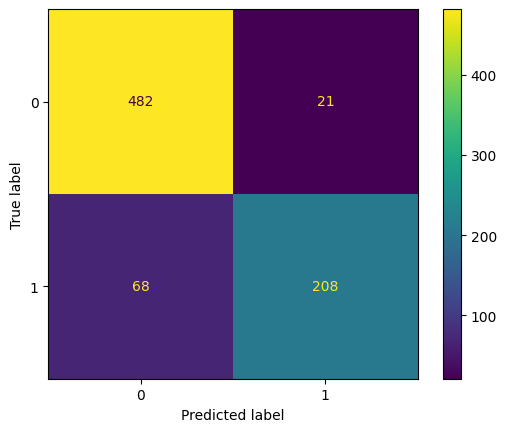

In [7]:
# display
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_vec, y_test)

In [9]:
# train test split
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# trying bigrams
tfidf_vectorizer_ngram = TfidfVectorizer(ngram_range=(1, 3))  # unigrams and bigrams
X_train_ngram = tfidf_vectorizer_ngram.fit_transform(X_train_)

In [21]:
# test data
X_test_ngram = tfidf_vectorizer_ngram.transform(X_test)

In [22]:
# Step 5: Fit the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_ngram, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# predictions
y_pred_ngrams = log_reg.predict(X_test_ngram)

In [24]:
# classification report
print(classification_report(y_test_, y_pred_ngrams))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       503
           1       0.94      0.64      0.77       276

    accuracy                           0.86       779
   macro avg       0.89      0.81      0.83       779
weighted avg       0.87      0.86      0.85       779



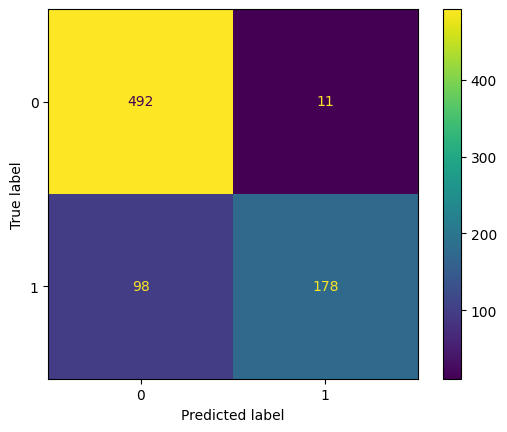

In [25]:
# display
ConfusionMatrixDisplay.from_estimator(log_reg, X_test_ngram, y_test_)

#### Stemming

In [27]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# stemmer function
def stem_reviews(reviews: pd.Series) -> pd.Series:
    ps = PorterStemmer()
    stemmed_reviews = reviews.apply(lambda review: ' '.join([ps.stem(word) for word in word_tokenize(review)]))
    return stemmed_reviews

In [31]:
stemmed = df.copy()
stemmed['stem'] = stem_reviews(stemmed['cleaned'])

In [32]:
stemmed.head()

,recommended,cleaned,stem
0,1,Very good flight following an equally good fli...,veri good flight follow an equal good flight t...
1,1,An hours delay due to late arrival of the inco...,an hour delay due to late arriv of the incom a...
2,0,I booked through BA because Loganair dont have...,i book through ba becaus loganair dont have re...
3,0,British airways lost bags in LHR then found th...,british airway lost bag in lhr then found them...
4,0,The check in process and reward loyalty progra...,the check in process and reward loyalti progra...


In [33]:
# split the data
X = stemmed['stem']
y = stemmed['recommended']

# split this data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# tfidf vectorizer
tfidf_stem = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# fit transform X_train, transform X_test
X_train_stem = tfidf_stem.fit_transform(X_train)
X_test_stem = tfidf_stem.transform(X_test)


In [40]:
# logistic regression model
log_stem = LogisticRegression(C=0.5, penalty='l2', max_iter=1000)

# fit
log_stem.fit(X_train_stem, y_train)

# predictions
stem_pred = log_stem.predict(X_test_stem)

In [41]:
# results
print(classification_report(y_test, stem_pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90       503
           1       0.92      0.68      0.78       276

    accuracy                           0.87       779
   macro avg       0.88      0.82      0.84       779
weighted avg       0.87      0.87      0.86       779



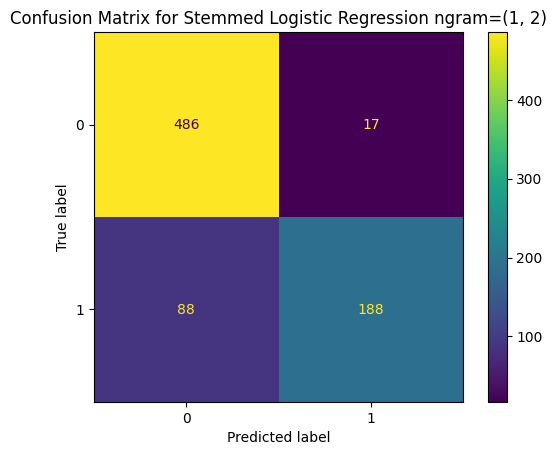

In [42]:
# display
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_estimator(log_stem, X_test_stem, y_test)
plt.title('Confusion Matrix for Stemmed Logistic Regression ngram=(1, 2)')
plt.show()

### Lemmatization Instead

In [44]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
# Function to map POS tags to WordNet format
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to perform lemmatization with POS tagging
def lemmatize_reviews(reviews: pd.Series) -> pd.Series:
    lemmatizer = WordNetLemmatizer()
    lemmatized_reviews = []
    for review in reviews:
        tokens = word_tokenize(review)
        pos_tags = pos_tag(tokens)
        lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
        lemmatized_reviews.append(' '.join(lemmatized))
    return pd.Series(lemmatized_reviews)

# call the function on a copy of our data
lemmatized_df = df.copy()
lemmatized_df['lemmatized'] = lemmatize_reviews(lemmatized_df['cleaned'])

lemmatized_df.head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,recommended,cleaned,lemmatized
0,1,Very good flight following an equally good fli...,Very good flight follow an equally good flight...
1,1,An hours delay due to late arrival of the inco...,An hour delay due to late arrival of the incom...
2,0,I booked through BA because Loganair dont have...,I book through BA because Loganair dont have r...
3,0,British airways lost bags in LHR then found th...,British airway lose bag in LHR then find them ...
4,0,The check in process and reward loyalty progra...,The check in process and reward loyalty progra...


In [45]:
# split the data
X = lemmatized_df['lemmatized']
y = lemmatized_df['recommended']

# split this data for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# tfidf vectorizer
tfidf_lemm = TfidfVectorizer(ngram_range=(1, 2), stop_words='english')

# fit transform X_train, transform X_test
X_train_lemm = tfidf_lemm.fit_transform(X_train)
X_test_lemm = tfidf_lemm.transform(X_test)

In [51]:
# logistic regression model
log_lemm = LogisticRegression(max_iter=1000)

# fit
log_lemm.fit(X_train_lemm, y_train)

# predictions
lemm_pred = log_lemm.predict(X_test_lemm)

In [52]:
# results
print(classification_report(y_test, lemm_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       503
           1       0.82      0.62      0.71       276

    accuracy                           0.82       779
   macro avg       0.82      0.77      0.79       779
weighted avg       0.82      0.82      0.81       779



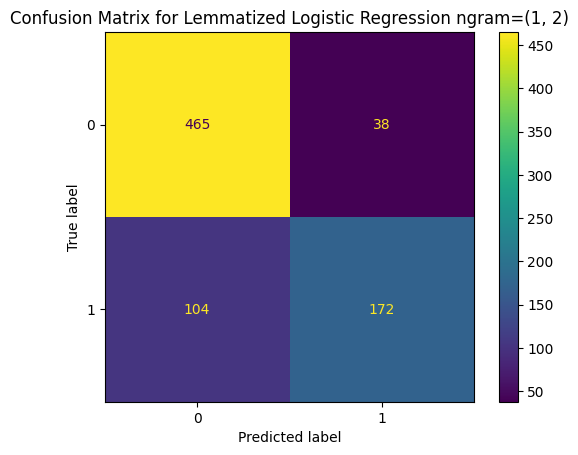

In [53]:
# display
ConfusionMatrixDisplay.from_estimator(log_lemm, X_test_lemm, y_test)
plt.title('Confusion Matrix for Lemmatized Logistic Regression ngram=(1, 2)')
plt.show()